In [19]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp

from dosipy.constants import eps_0
from dosipy.field import efield, hfield
from dosipy.utils.dataloader import (load_tissue_diel_properties,
                                     load_antenna_el_properties)
from dosipy.utils.integrate import elementwise_quad, elementwise_rectquad
from dosipy.utils.derive import holoborodko

from utils import reflection_coefficient

In [10]:
# working frequency, Hz
f = 100e9

# peak incident power density, W/m2
ipd = 100

# dry skin density, kg/m3
rho = 1109

# conductivity, relative permitivitya and penetration depth
sigma, eps_r, _, pen_depth = load_tissue_diel_properties('skin_dry', f)
L = pen_depth / 2  # energy penetration depth in m

# reflection coefficient
eps_i = sigma / (2 * np.pi * f * eps_0)
eps = eps_r - 1j * eps_i
gamma = reflection_coefficient(eps)

# power transmission coefficient
T_tr = 1 - gamma ** 2

In [54]:
# antenna electric properties (Poljak 2005)
antenna_data = load_antenna_el_properties(f)

# antenna position -- coordinates
xs = antenna_data.x.to_numpy()
xs = xs - xs.max() / 2
xs = jnp.asarray(xs)
ys = jnp.zeros_like(xs)
zs = jnp.zeros_like(xs)

# current through the antenna
Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
Is_x = holoborodko(Is, xs[1]-xs[0])

# solution domain setup
target_area = (0.02, 0.02)  # meters x meters
z_max = 0.02  # in meters
A = target_area[0] * target_area[1]  # meters^2
h = 5 / 1000  # distance from the antenna
xt = jnp.linspace(-target_area[0]/2, target_area[0]/2)
yt = jnp.linspace(-target_area[1]/2, target_area[1]/2)
zt = jnp.linspace(h, h + z_max)

In [57]:
# compute E and H field components on the exposed surface
Ex = np.empty((xt.size, yt.size), dtype=np.complex128)
Ey = np.empty((xt.size, yt.size), dtype=np.complex128)
Ez = np.empty((xt.size, yt.size), dtype=np.complex128)
Hx = np.empty((xt.size, yt.size), dtype=np.complex128)
Hy = np.empty((xt.size, yt.size), dtype=np.complex128)
Hz = np.empty((xt.size, yt.size), dtype=np.complex128)
for xi, _xt in enumerate(xt):
    for yi, _yt in enumerate(yt):
        _Ex, _Ey, _Ez = efield(_xt, _yt, h, xs, ys, zs, Is, f)
        _Hx, _Hy, _Hz = hfield(_xt, _yt, h, xs, ys, zs, Is, f)
        Ex[xi, yi] = _Ex
        Ey[xi, yi] = _Ey
        Ez[xi, yi] = _Ez
        Hx[xi, yi] = _Hx
        Hy[xi, yi] = _Hy
        Hz[xi, yi] = _Hz

In [61]:
# compute ipd on the surface
Sx = Ey * Hz.conjugate() - Ez * Hy.conjugate()
Sy = Ex * Hz.conjugate()
Sz = Ex * Hy.conjugate()
ipd_surf = np.abs(np.sqrt(Sx ** 2 + Sy ** 2 + Sz **2))
ipd = 1 / (2 * A) * elementwise_rectquad(xt, yt, ipd_surf)
ipd

7.71771577120734

In [62]:
# compute sar in the exposed volume
Xt, Yt = np.meshgrid(xt, yt)
sar_surf = ipd_surf * T_tr / (rho * L)
sar = np.outer(
    sar_surf, np.exp(-z / L)
).reshape(*sar_surf.shape, *zt.shape)

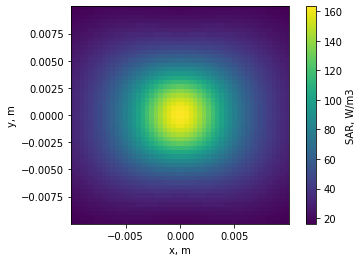

In [63]:
bbox = [xt.min(), xt.max(), yt.min(), yt.max()]
cm = plt.imshow(sar_surf, extent=bbox, origin='lower')
bar = plt.colorbar(cm, label='SAR, W/m3')
plt.xlabel('x, m')
plt.ylabel('y, m')
plt.show()

In [76]:
# compute tpd
tpd_surf = np.zeros_like(sar_surf)
for i in range(sar_surf.shape[0]):
    for j in range(sar_surf.shape[1]):
        tpd_surf[i, j] = elementwise_quad(zt, sigma * sar[i, j, :], degree=31)
tpd = 1 / (2 * A) * elementwise_rectquad(xt, yt, tpd_surf)
tpd

0.2640508114243069

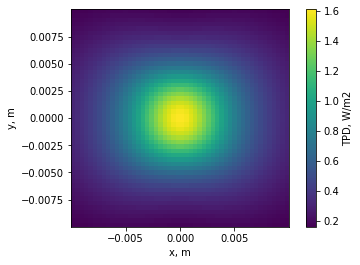

In [85]:
cm = plt.imshow(tpd_surf, extent=bbox, origin='lower')
bar = plt.colorbar(cm, label='TPD, W/m2')
plt.xlabel('x, m')
plt.ylabel('y, m')
plt.show()